In [1]:
from functions import *

# Nu vs strength of downward flow

## Load one example

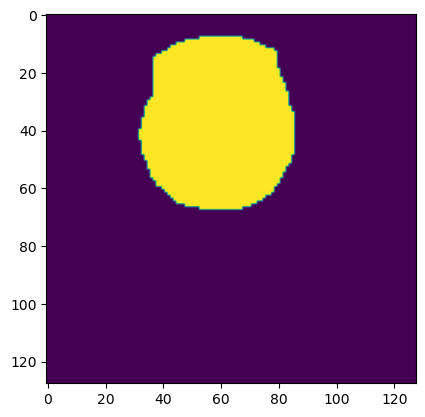

In [ ]:
# load image and its contour
PIV_img = cv2.imread('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-06/analysis_S10_81mm/Cam_Date=231103_Time=095403_S10_81mm_redcontour.png')

hsv_img = cv2.cvtColor(PIV_img, cv2.COLOR_RGB2HSV)
low = (0*2*np.pi/360, 255, 255)
high = (360*2*np.pi/360, 255, 255)
square = np.full((10, 10, 3), high, dtype=np.uint8) / 255.
mask = np.expand_dims(hsv_img[:,:,0]==120,axis=2)[::8,::8,:]
im = plt.imshow(mask)

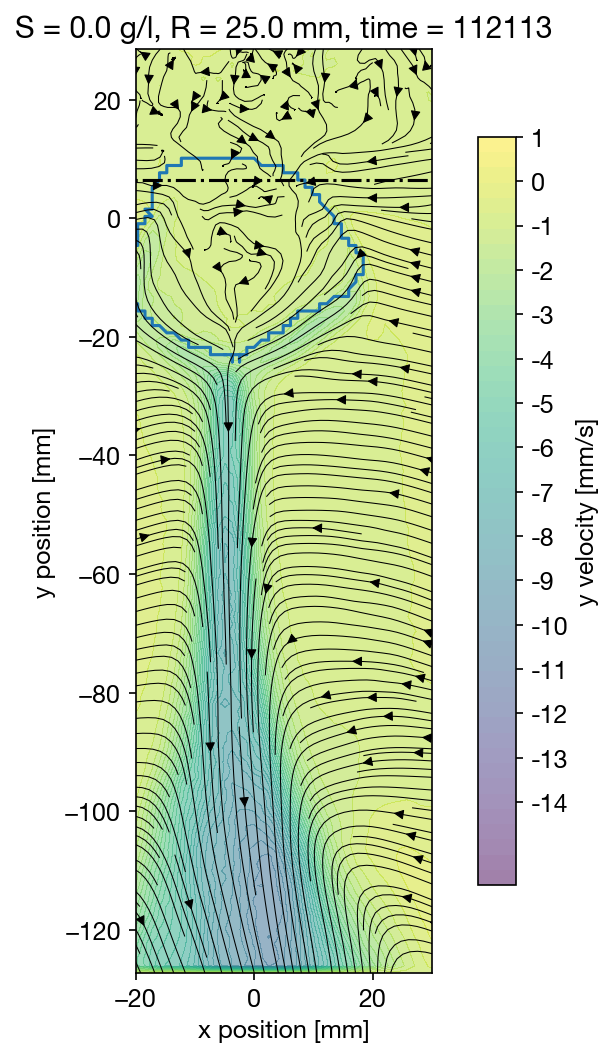

In [3]:
pivDirectory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-06/'
chosen_salt,chosen_radius,chosen_time = 0.,0.025,'112113'

it=-1
folders = []

for folder in glob.glob(pivDirectory+'Cam*'):
    folders.append(folder)
folders = np.sort(folders)

for folder in folders:
    date = folder[93:99]
    time = str(folder[105:111])
    exp_sal = float(folder[113:115])
    exp_radius = int(folder[116:118])/2000
    if exp_radius == 0.006: exp_radius=0.06
    if exp_radius==chosen_radius and exp_sal==chosen_salt and time==chosen_time:
        it +=1
        # read data
        pivData = np.genfromtxt(glob.glob(folder+'/*.txt')[0]).T
        break
    # if it==4:break

for ic,contourPATH in enumerate(glob.glob(folder+'/*.csv')):
    contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
    if contour.shape[1]!=2: contour = contour.T

x,y,u,v = pivData
# u = np.ma.array(u, mask=mask) # ONLY IF MASK EXISTS
side = np.sqrt(x.shape[0]).astype(int)


# regularly spaced grid spanning the domain of x and y 
xi = np.linspace(x.min(), x.max(), side)
yi = np.linspace(y.min(), y.max(), side)
X,Y = np.meshgrid(xi,yi)

ui = np.reshape(u,(side,side))[::-1,:]
vi = np.reshape(v,(side,side))[::-1,:]

plt.figure(figsize=(8,8),dpi=150)
pc = contour/1024*128 # plot contour
plt.plot(xi[pc[:,0].astype(int)],yi[-pc[:,1].astype(int)])
plt.hlines(yi[(findWL(-pc)).astype(int)],-30,30,colors='k',linestyles='-.',label='water level')
im = plt.contourf(X,Y,vi,levels=np.linspace(-16e-3,2e-3,50),alpha=.5)
cbar = plt.colorbar(im,label='y velocity [mm/s]',shrink=0.81,ticks=np.linspace(-14e-3,2e-3,16),alpha=0.2)
cbar.ax.set_yticklabels(np.around(np.arange(-14,2,1),2))
plt.streamplot(X,Y,ui,vi,color='black',linewidth=.5,density=4)
# plt.imshow(PIV_img,extent=(xi[0],xi[-1],yi[0],yi[-1]),vmax=0.4*PIV_img.max(),cmap='Greys_r') # ONLY FOR MASK
# plt.hlines(9.5,-20,60,colors='tab:blue')
# plt.hlines(3,-20,60,colors='tab:orange')
plt.xlabel('x position [mm]')
plt.ylabel('y position [mm]')
plt.gca().set_aspect('equal')
plt.title(f'S = {exp_sal} g/l, R = {exp_radius*1e3} mm, time = {time}')
plt.xlim(-20,30)
# plt.ylim(-85,25)
# plt.savefig(pivDirectory+f'analysis_S10_81mm/{time}.png',format='png',bbox_inches='tight')
plt.show()
del pivData

In [25]:
yi[(findWL(-pc)).astype(int)]

6.441652755905494

## Find u gradient

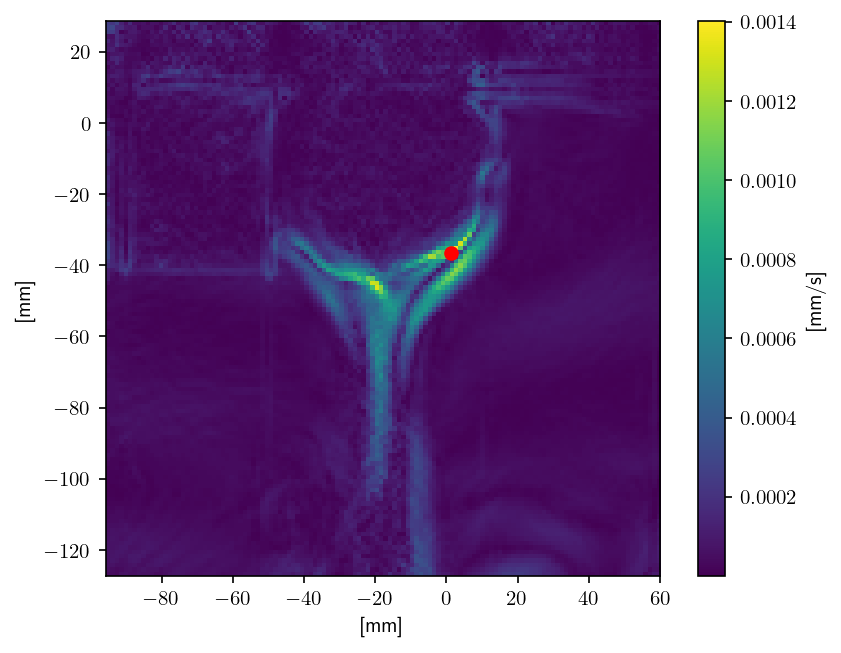

In [ ]:
# where it converges the most, that's the bottom of the ice
plt.figure(dpi=150)
ugradient = np.sqrt(np.gradient(ui)[0]**2+np.gradient(ui)[1]**2)[2:,:-2]
im = plt.imshow(ugradient,extent=(xi[0],xi[-1],yi[-1],yi[0]),)
plt.scatter(xi[np.where(ugradient==np.max(ugradient))[1]],
            yi[np.where(ugradient==np.max(ugradient))[0]],
            c='red')
plt.colorbar(im,label='[mm/s]')
plt.gca().invert_yaxis()
plt.xlabel('[mm]',usetex=True)
plt.ylabel('[mm]')
plt.show()


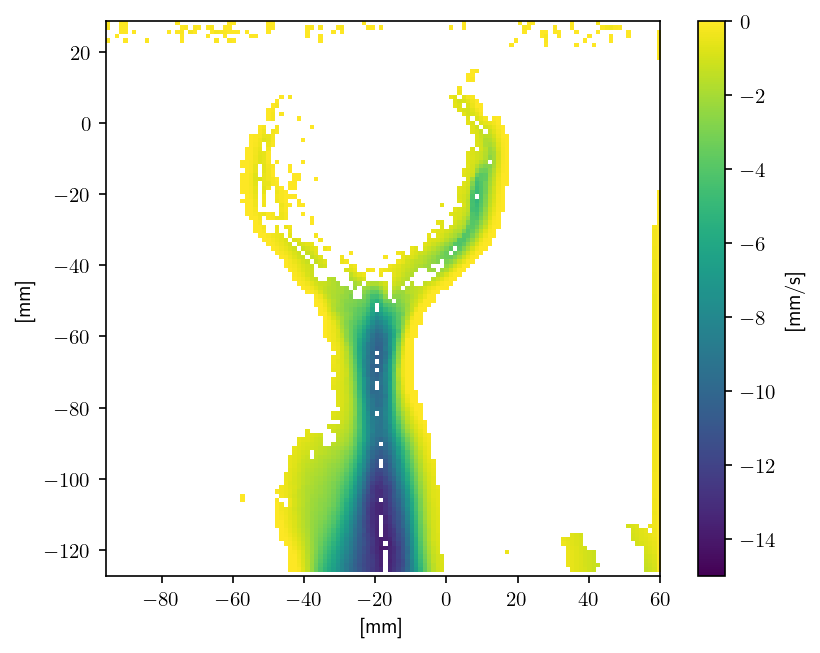

/var/folders/dv/4xxtrbpd4ql97bd1_v6ctglh0000gn/T/ipykernel_38930/2300334987.py:20: RuntimeWarning: Mean of empty slice
  ssum = np.nanmean(cleanVi*1000,axis=1)[:int(ymax)]


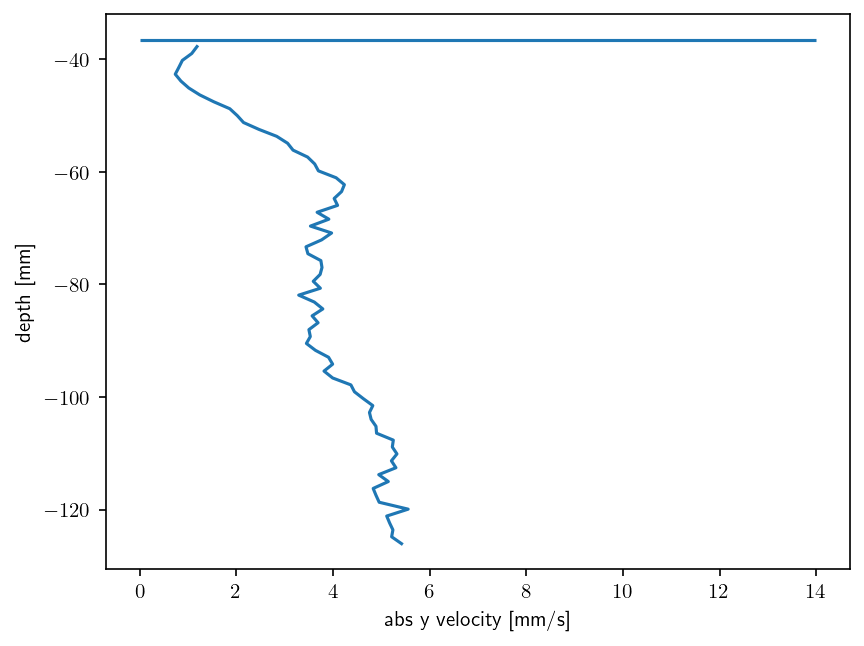

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    # "font.family": "Helvetica"
})
plt.figure(dpi=150)
cleanVi = np.where(vi>-0.001,np.nan,vi)
cleanVi = np.where(abs(np.gradient(vi)[1])>1e-4,vi,np.nan)
im = plt.imshow(cleanVi*1000,extent=(xi[0],xi[-1],yi[-1],yi[0]),vmin=-15,vmax=0)
plt.colorbar(im,label='[mm/s]')
plt.gca().invert_yaxis()
plt.xlabel('[mm]',usetex=True)
plt.ylabel('[mm]')
plt.show()

ugradient = np.sqrt(np.gradient(ui)[0]**2+np.gradient(ui)[1]**2)[2:,:-2]
ymax=np.where(ugradient==np.max(ugradient))[0]

plt.figure(dpi=150)
ssum = np.nanmean(cleanVi*1000,axis=1)[:int(ymax)]
cleanedSum = abs(np.where(ssum==0.,np.nan,ssum))
plt.plot(cleanedSum,yi[:int(ymax)])
# plt.plot(np.nanmin(cleanVi,axis=1)*1000,yi)
plt.hlines(yi[ymax],14,0)
plt.xlabel('abs y velocity [mm/s]')
plt.ylabel('depth [mm]')
plt.show()

## Apply to all

/var/folders/dv/4xxtrbpd4ql97bd1_v6ctglh0000gn/T/ipykernel_23794/2314477236.py:90: RuntimeWarning: All-NaN slice encountered
  w = abs(np.nanmin(cleanVi[indexMinimum:,:])) # horizontal nanmin of vertical velocities IT ALSO WORKS WITH nanmean


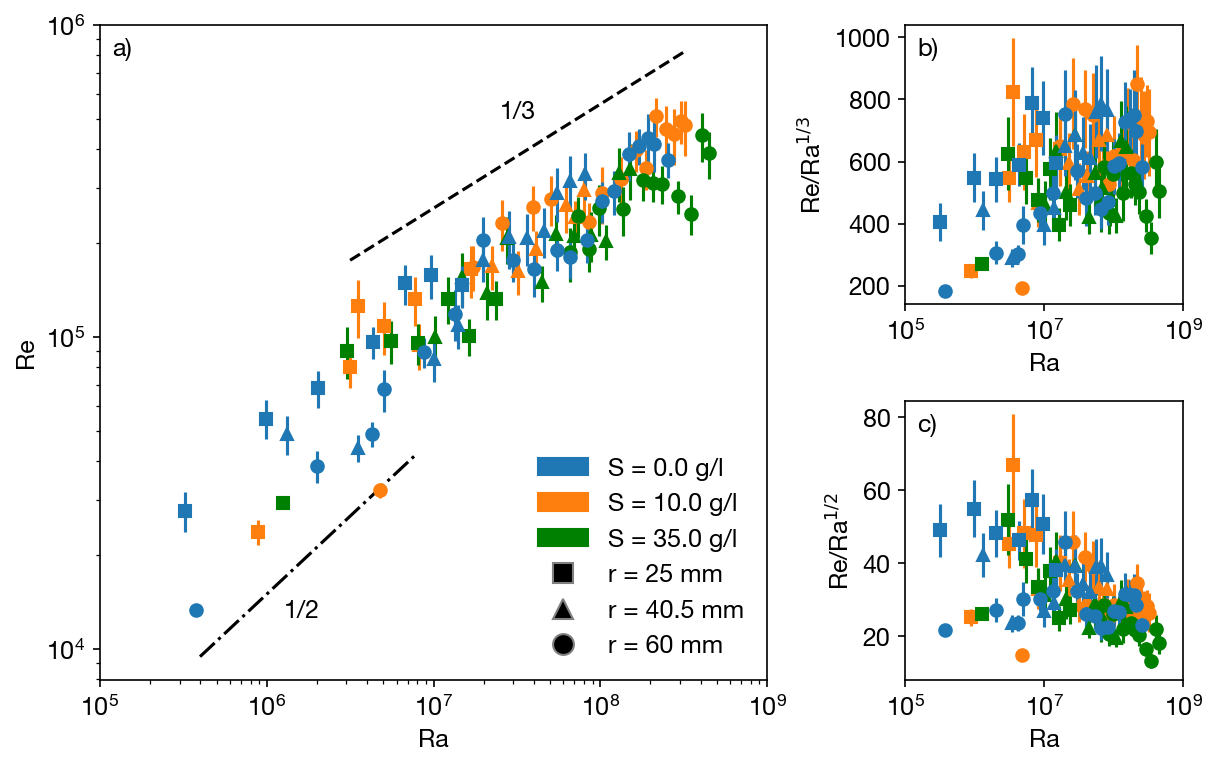

In [36]:
def Ra_salinity(r,T1,T2,S=0):
    """Calculates Rayleigh number for a cylinder in (possibly salty) water, given radius,salinity, and two temperatures. 
    The density is calculated according to Millero and Huang, 2009.

    Args:
        r (float): cylinder's radius [m]
        S (float,optional): water salinity [g/l], Defaults to 0 g/l.
        T1 (float): temperature 1 [degC]
        T2 (float): temperature 2 [degC]

    Returns:
        float: Rayleigh number
    """    
    T_min = min(T1,T2)
    T_max = max(T1,T2)
    rho1 = MH_rho(T_min,S=S) # fresh, cold water
    rho2 = MH_rho(T_max,S=S)
    rho_avg = np.mean((rho1,rho2))

    deltaRho = abs(rho1-rho2)
    return g*deltaRho*(2*r)**3/(alpha*nu*rho_avg)


myColours = np.repeat(['tab:blue','tab:orange','green','purple','red','cyan','brown','pink','grey','olive',
                       'black','lime'],1)
myMarkers = ['s','^','o']

pivDirectory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-06/'
chosen_salts,chosen_radii = [0.,10.,35.],[0.025,0.0405,0.06]

fig, axs = plt.subplot_mosaic([['a)', 'a)','b)'], ['a)','a)', 'c)']],
                              layout='constrained',dpi=150,width_ratios=[1.2, 1.2, 1],
                              figsize=(8,5))

it=-1
folders = []
abscissa = []
ordinate = []
error = []

for folder in glob.glob(pivDirectory+'*'):
    folders.append(folder)
folders = np.sort(folders)

for _,folder in enumerate(folders):
    if 'NR' in folder or 'analysis' in folder: continue # there are folders with no good data in them
    date = folder[93:99]
    timestring = folder[105:111]
    exp_sal = float(folder[113:115])
    exp_radius = int(folder[116:118])/2000
    if exp_radius == 0.006: exp_radius=0.06
    
    if exp_radius not in chosen_radii or exp_sal not in chosen_salts:
        continue
    else:
        it +=1

    if timestring == '120643': 
        it -= 1
        continue # THIS SKIPS A BAD IMAGE ON THE .0405 S00 DATA

    timeOfExp = np.datetime64(f'20{date[:2]}-{date[2:4]}-{date[-2:]}T{timestring[:2]}:{timestring[2:4]}:{timestring[-2:]}')
    
    # read contorus data and make average Ra (over 2 shots...)
    Rayleigh_numbers = 0
    for ic,contourPATH in enumerate(glob.glob(folder+'/*.csv')):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])*.917/np.pi) # CORRECTION TO CONSIDER ONLY IMMERSED PART.
        conversion = 1024*1000/abs(yi[-1]-yi[0]) # px/m
        radius /= conversion
        Rayleigh_numbers += Ra_salinity(radius,4,20.,S=exp_sal)
    Rayleigh_numbers /= ic

    # read PIV data
    pivData = np.genfromtxt(glob.glob(folder+'/*.txt')[0]).T
    x,y,u,v = pivData
    side = np.sqrt(x.shape[0]).astype(int)

    # regularly spaced grid spanning the domain of x and y 
    xi = np.linspace(x.min(), x.max(), side)
    yi = np.linspace(y.min(), y.max(), side)
    X,Y = np.meshgrid(xi,yi)

    ui = np.reshape(u,(side,side))[::-1,:]
    vi = np.reshape(v,(side,side))[::-1,:]

    cleanVi = np.where(vi>-0.0015,np.nan,vi) # simple thresholding of vertical velocities. 
    indexMinimum = np.min(-(contour/1024*128)[:,1].astype(int))-2 # location of bottom of ice
    w = abs(np.nanmin(cleanVi[indexMinimum:,:])) # horizontal nanmin of vertical velocities IT ALSO WORKS WITH nanmean
    wstd = abs(np.nanstd(cleanVi[indexMinimum:,:]))
    axs['a)'].errorbar(x=Rayleigh_numbers,
                 y=w*1000*2*radius/nu,
                 yerr=wstd*1000*2*radius/nu,
                 marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
                 c=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]])
    if not np.isnan(w):
        abscissa.append(Rayleigh_numbers)
        ordinate.append(w*1000*2*radius/nu)
        error.append(wstd*1000*2*radius/nu)
    axs['b)'].errorbar(x=Rayleigh_numbers,
                 y=w*1000*2*radius/nu/ Rayleigh_numbers**(1/3),
                 yerr=wstd*1000*2*radius/nu / Rayleigh_numbers**(1/3),
                 marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
                 c=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]])
    axs['c)'].errorbar(x=Rayleigh_numbers,
                 y=w*1000*2*radius/nu/ Rayleigh_numbers**(1/2),
                 yerr=wstd*1000*2*radius/nu / Rayleigh_numbers**(1/2),
                 marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
                 c=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]])
    

axs['a)'].plot(np.logspace(6.5,8.5,50),1200*np.logspace(6.5,8.5,50)**(1/3),linestyle='--',c='k')
axs['a)'].annotate('1/3', xy=(10**7.4,10**5.7))
# axs['a)'].plot(np.logspace(7.6,8.7,50),100*np.logspace(7.6,8.5,50)**(2/5),linestyle='dotted',c='k')
# axs['a)'].annotate('2/5', xy=(10**8.2,10**5.2))
axs['a)'].plot(np.logspace(5.6,6.9,50),15*np.logspace(5.6,6.9,50)**(1/2),linestyle='-.',c='k')
axs['a)'].annotate('1/2', xy=(10**6.1,10**4.1))
for label,axi in axs.items():
    axi.set(xlabel='Ra',xscale='log',
            xlim=(1e5,1e9))
    axi.annotate(
        label,
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        verticalalignment='top',
        bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
axs['a)'].set(ylabel='Re',ylim=(10**3.9,10**6.0),yscale='log')
axs['b)'].set(ylabel=r'Re/Ra$^{1/3}$')
axs['c)'].set(ylabel=r'Re/Ra$^{1/2}$')

# access legend objects automatically created from data
handles, labels = axs['a)'].get_legend_handles_labels()

# create manual symbols for legend
patch0 = mpatches.Patch(color=myColours[0], label='S = 0.0 g/l')   
patch1 = mpatches.Patch(color=myColours[1], label='S = 10.0 g/l')   
patch2 = mpatches.Patch(color=myColours[2], label='S = 35.0 g/l')   
point0 = Line2D([0], [0], label='r = 25 mm', marker=myMarkers[0], markersize=10, 
         markeredgecolor='grey', markerfacecolor='k', linestyle='')
point1 = Line2D([0], [0], label='r = 40.5 mm', marker=myMarkers[1], markersize=10, 
         markeredgecolor='grey', markerfacecolor='k', linestyle='')
point2 = Line2D([0], [0], label='r = 60 mm', marker=myMarkers[2], markersize=10, 
         markeredgecolor='grey', markerfacecolor='k', linestyle='')

# add manual symbols to auto legend
handles.extend([patch0, patch1, patch2, point0,point1,point2])
axs['a)'].legend(handles=handles,loc='lower right',frameon=False)

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/ReRa.pdf',format='pdf',bbox_inches='tight')
plt.show()

## Best fit

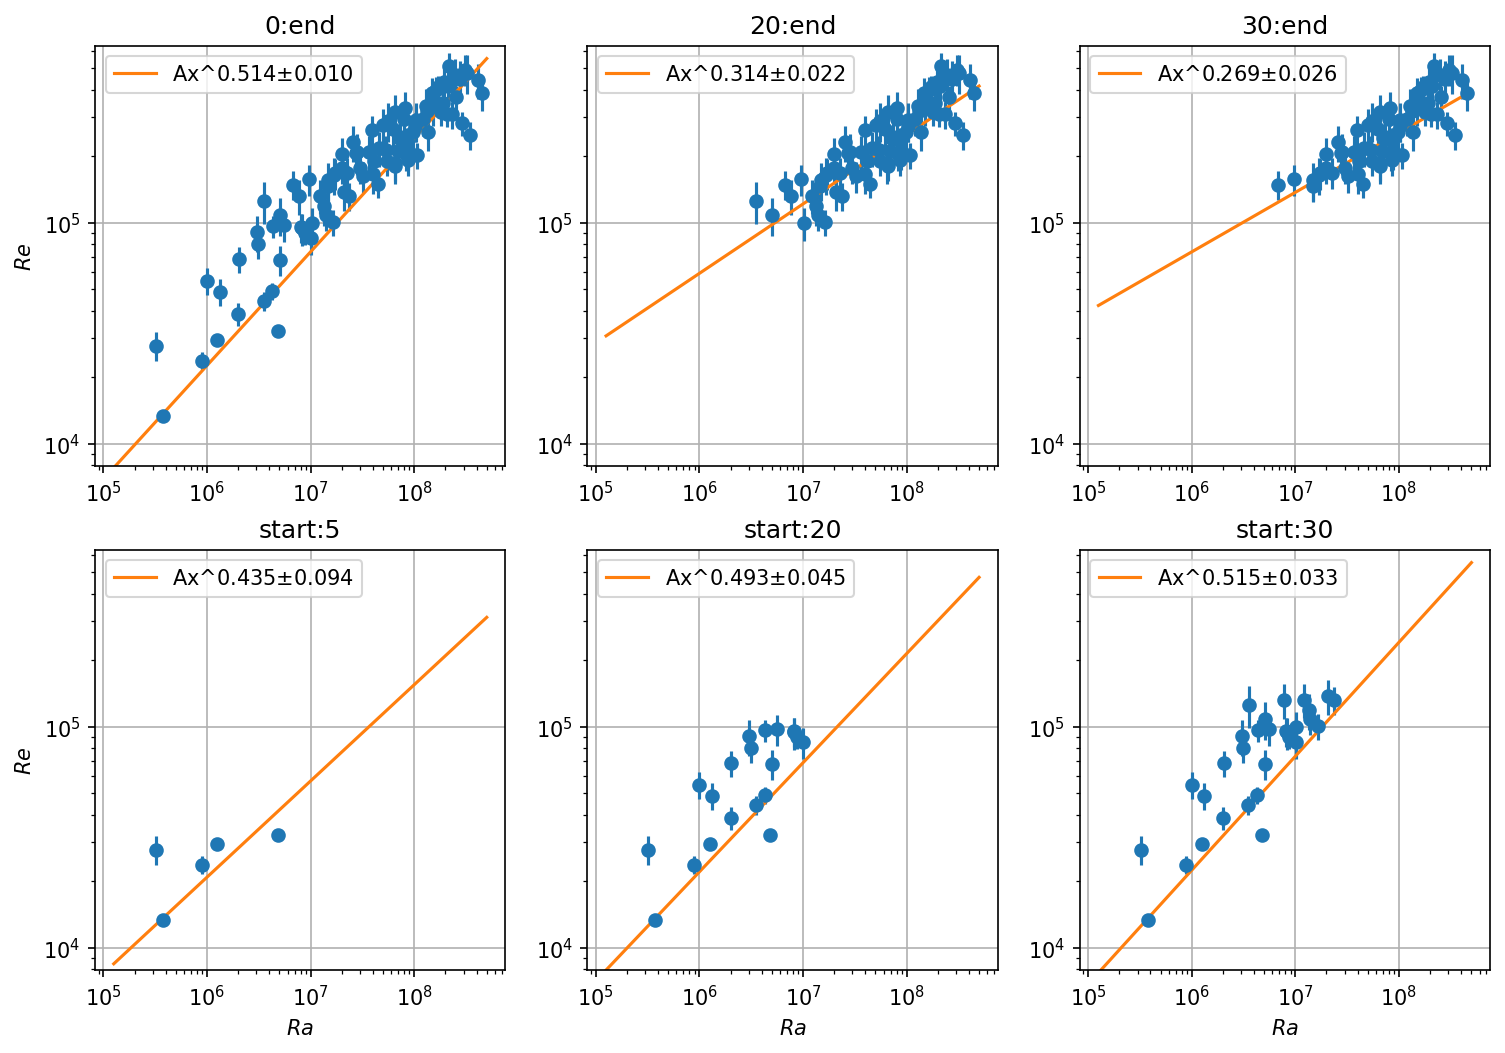

In [140]:
def powerlaw(x,intercept,exponent):
    return intercept*x**exponent
plt.rcParams['text.usetex'] = False

_,axs = plt.subplots(nrows=2,ncols=3,dpi=150,figsize=(12,8))

for i,cut in enumerate([0,20,30,5,20,30]):
    data = np.vstack((abscissa,ordinate,error)).T
    data = data[data[:, 1].argsort()].T
    ax = axs.flatten()[i]
    if i<=2:
        data = data[:,cut:]
    else:
        data = data[:,:cut]

    ax.errorbar(data[0,:],data[1,:],data[2,:],marker='o',linestyle='none')
    popt,pcov = curve_fit(f=powerlaw,xdata=data[0],ydata=data[1],sigma=data[2])
    perr = np.sqrt(np.diag(pcov))
    ax.plot(np.logspace(5.1,8.7,50),popt[0]*np.logspace(5.1,8.7,50)**popt[1],
            label=f'Ax^{popt[1]:.3f}'+r'$\pm$'+f'{perr[1]:.3f}')
    ax.legend(loc='upper left')
    ax.set(xscale='log',yscale='log',
           ylabel='$Re$',xlabel='$Ra$',ylim=(10**3.9,10**5.8))
    if i !=0 and i !=3: ax.set(ylabel='')
    if i<=2:
        ax.set(xlabel='',title=f'{cut}:end',)
    else:
        ax.set(title=f'start:{cut}')
    ax.grid()
plt.show()